In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

## Loading data

In [2]:
train=pd.read_csv('data/TrainData4.csv')
input_data=pd.read_csv('data/WeatherForecastInput4.csv')
train.head()

,TIMESTAMP,POWER,U10,V10,U100,V100
0,20150101 00:00,NaN,NaN,NaN,NaN,NaN
1,20150101 01:00,NaN,6.24102,3.49613,9.73707,4.78492
2,20150101 02:00,NaN,5.62234,4.06239,8.94497,5.71768
3,20150101 03:00,0.666693,5.99531,4.89334,9.52143,6.99094
4,20150101 04:00,NaN,6.90809,4.79099,10.63280,6.75417


In [3]:
train.describe()

,POWER,U10,V10,U100,V100
count,27261.000000,27720.000000,27720.000000,27720.000000,27720.000000
mean,0.517775,2.211316,0.721899,3.028746,1.079522
std,0.313800,5.125725,4.502973,7.042252,6.172539
min,0.000000,-11.649200,-18.724500,-15.922300,-25.071400
25%,0.227213,-1.885478,-2.539125,-2.400520,-3.432050
50%,0.538978,2.690965,0.761054,3.794965,1.049430
75%,0.810858,6.005790,3.838205,8.187487,5.350662
max,1.000000,21.876300,18.122800,31.050900,25.117400


## Preprocessing

In [4]:
train['TIMESTAMP']=pd.to_datetime(train['TIMESTAMP'],format="%Y%m%d %H:%M")

In [5]:
train=train.set_index("TIMESTAMP")

### Inputing with interpolation

In [6]:
train['FillInterp']=train['POWER'].interpolate(method="time")

In [7]:
train = train.assign(MISSING= np.nan)
train.MISSING[train.POWER.isna()] = train.FillInterp

In [8]:
train.head()

,POWER,U10,V10,U100,V100,FillInterp,MISSING
TIMESTAMP,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,NaN,6.24102,3.49613,9.73707,4.78492,NaN,NaN
2015-01-01 02:00:00,NaN,5.62234,4.06239,8.94497,5.71768,NaN,NaN
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,0.666693,NaN
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,0.756962,0.756962


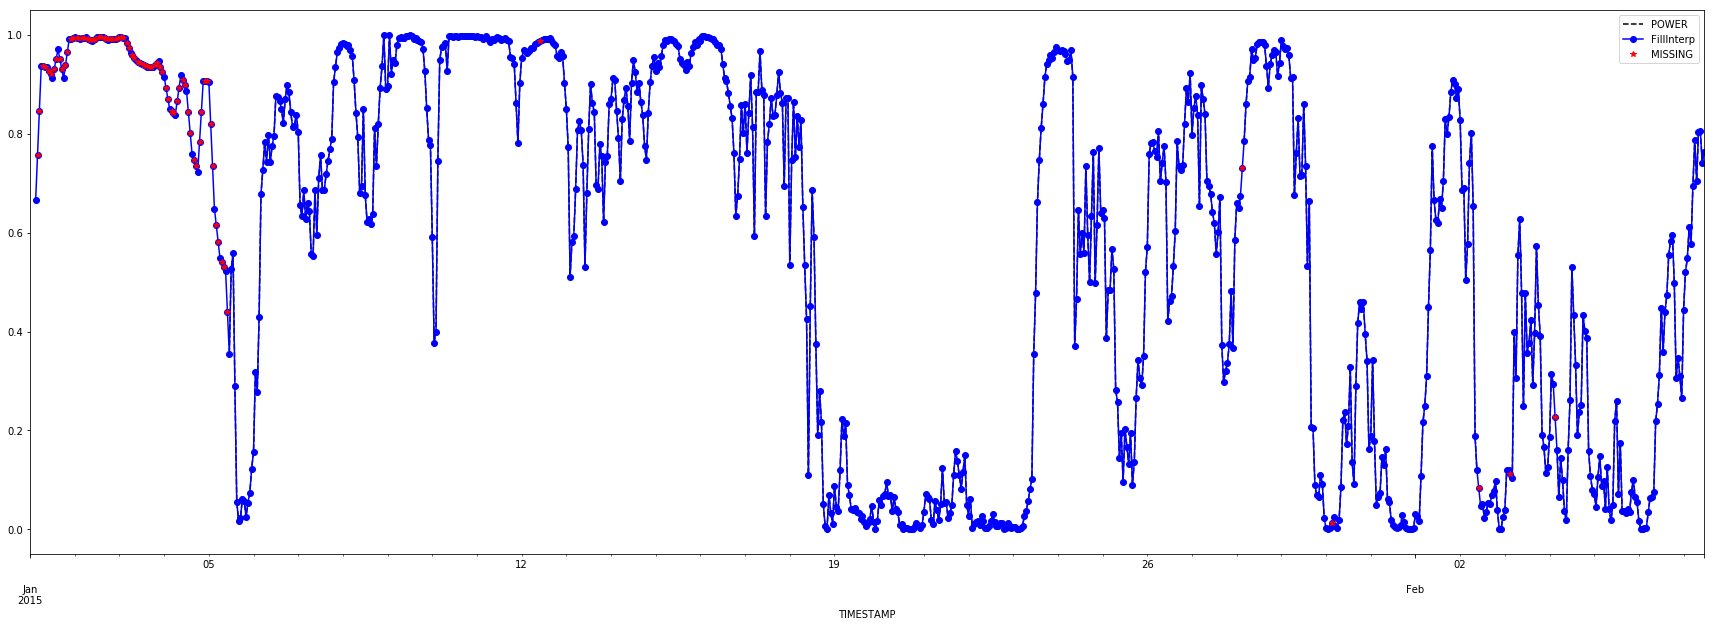

In [9]:
train[['POWER','FillInterp','MISSING']].head(900).plot(style=['k--', 'bo-', 'r*'], figsize=(30, 10))
plt.show()

### Inputing with mean/median

In [10]:
#Use assign to avoid pandas warning
train = train.assign(FillMean=train.POWER.fillna(train.POWER.mean()))
train = train.assign(FillMedian=train.POWER.fillna(train.POWER.median()))

In [11]:
train.head()

,POWER,U10,V10,U100,V100,FillInterp,MISSING,FillMean,FillMedian
TIMESTAMP,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517775,0.538978
2015-01-01 01:00:00,NaN,6.24102,3.49613,9.73707,4.78492,NaN,NaN,0.517775,0.538978
2015-01-01 02:00:00,NaN,5.62234,4.06239,8.94497,5.71768,NaN,NaN,0.517775,0.538978
2015-01-01 03:00:00,0.666693,5.99531,4.89334,9.52143,6.99094,0.666693,NaN,0.666693,0.666693
2015-01-01 04:00:00,NaN,6.90809,4.79099,10.63280,6.75417,0.756962,0.756962,0.517775,0.538978


### Inputing with rolling mean/median

In [12]:
train = train.assign(FillRollingMean=train.POWER.fillna(train.POWER.rolling(24,min_periods=1).mean()))
train = train.assign(FillRollingMedian=train.POWER.fillna(train.POWER.rolling(24,min_periods=1).median()))


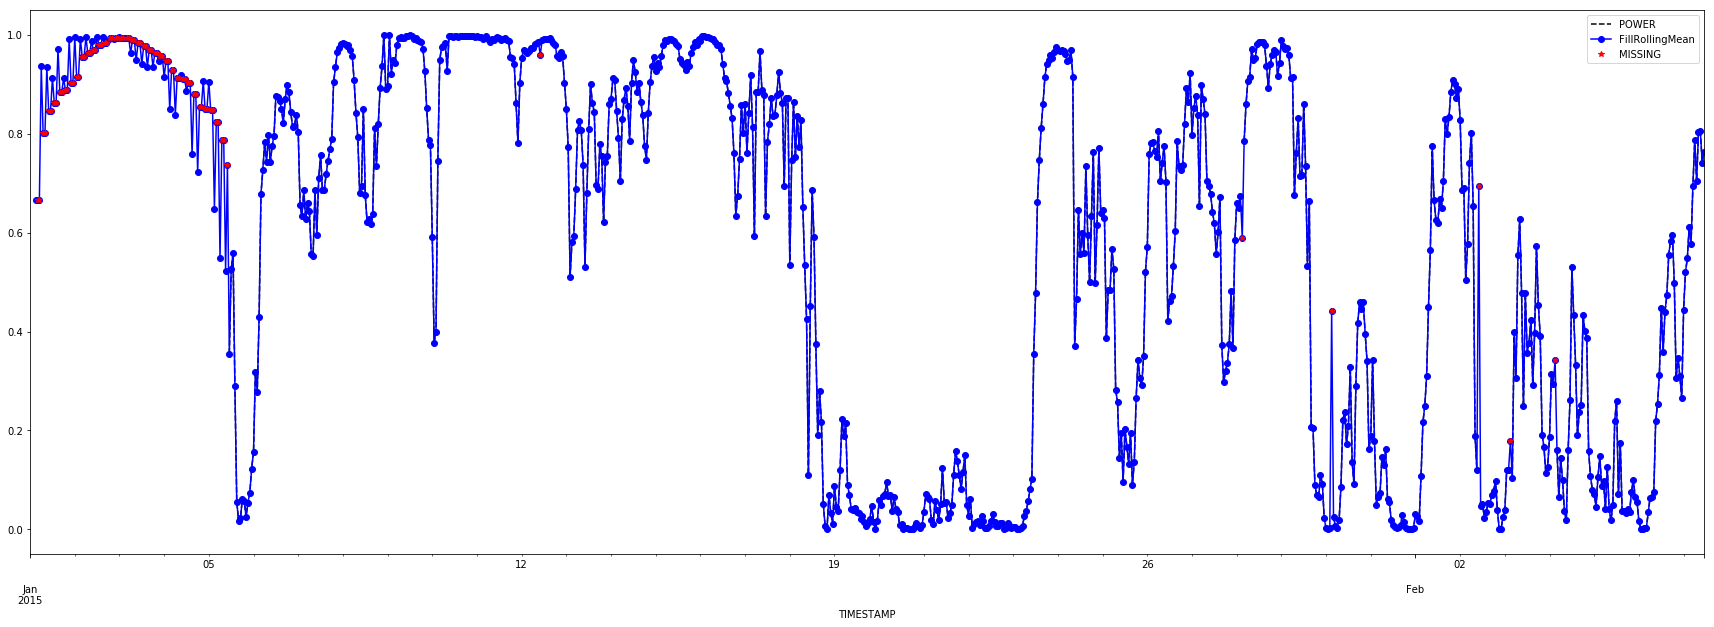

In [13]:
train = train.assign(MISSING= np.nan)
train.MISSING[train.POWER.isna()] = train.FillRollingMean
train[['POWER','FillRollingMean','MISSING']].head(900).plot(style=['k--', 'bo-', 'r*'], figsize=(30, 10))
plt.show()

### Seasonality

In [14]:
target_column="FillInterp"
df=train.dropna(subset=[target_column])

In [15]:
df.describe()

,POWER,U10,V10,U100,V100,FillInterp,MISSING,FillMean,FillMedian,FillRollingMean,FillRollingMedian
count,27261.000000,27718.000000,27718.000000,27718.000000,27718.000000,27718.000000,309.000000,27718.000000,27718.000000,27570.000000,27570.000000
mean,0.517775,2.211047,0.721679,3.028290,1.079221,0.516589,0.596900,0.517775,0.518124,0.518661,0.518849
std,0.313800,5.125812,4.503060,7.042302,6.172658,0.313979,0.273781,0.311203,0.311214,0.313487,0.313709
min,0.000000,-11.649200,-18.724500,-15.922300,-25.071400,0.000000,0.033619,0.000000,0.000000,0.000000,0.000000
25%,0.227213,-1.885653,-2.539155,-2.401460,-3.432170,0.224933,0.440919,0.233023,0.233023,0.228445,0.228299
50%,0.538978,2.690410,0.760934,3.794790,1.048895,0.536184,0.640315,0.528928,0.538978,0.539951,0.540495
75%,0.810858,6.005650,3.837892,8.186798,5.349997,0.810184,0.832781,0.806983,0.806983,0.810987,0.811347
max,1.000000,21.876300,18.122800,31.050900,25.117400,1.000000,0.993474,1.000000,1.000000,1.000000,1.000000


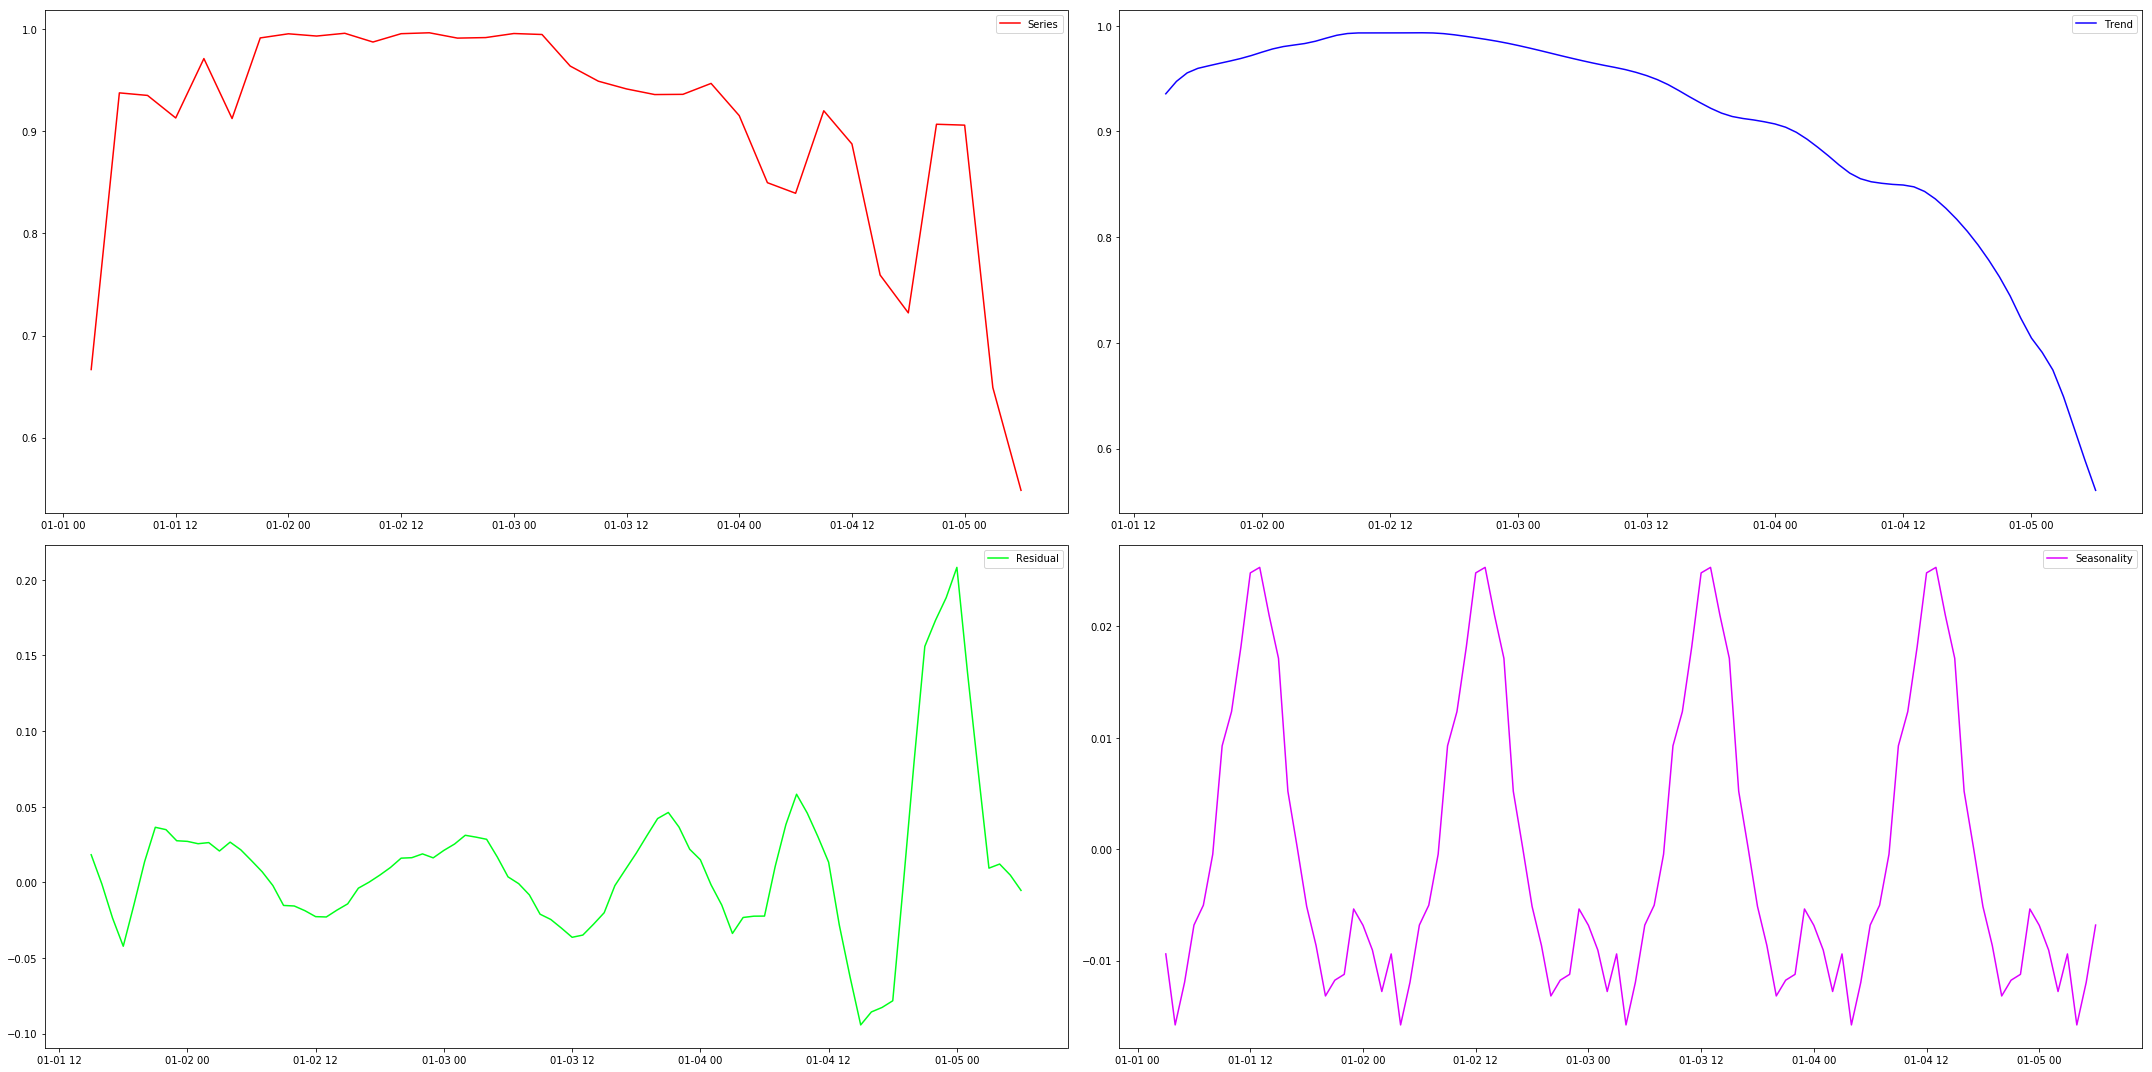

In [16]:
series=df[target_column]
decomposition=seasonal_decompose(series, model='additive')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
thresh=100
plt.figure(figsize=(30,15))
plt.subplot(221)
plt.plot(series.iloc[:100],color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend.iloc[:100],color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual.iloc[:100],color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal.iloc[:100],color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

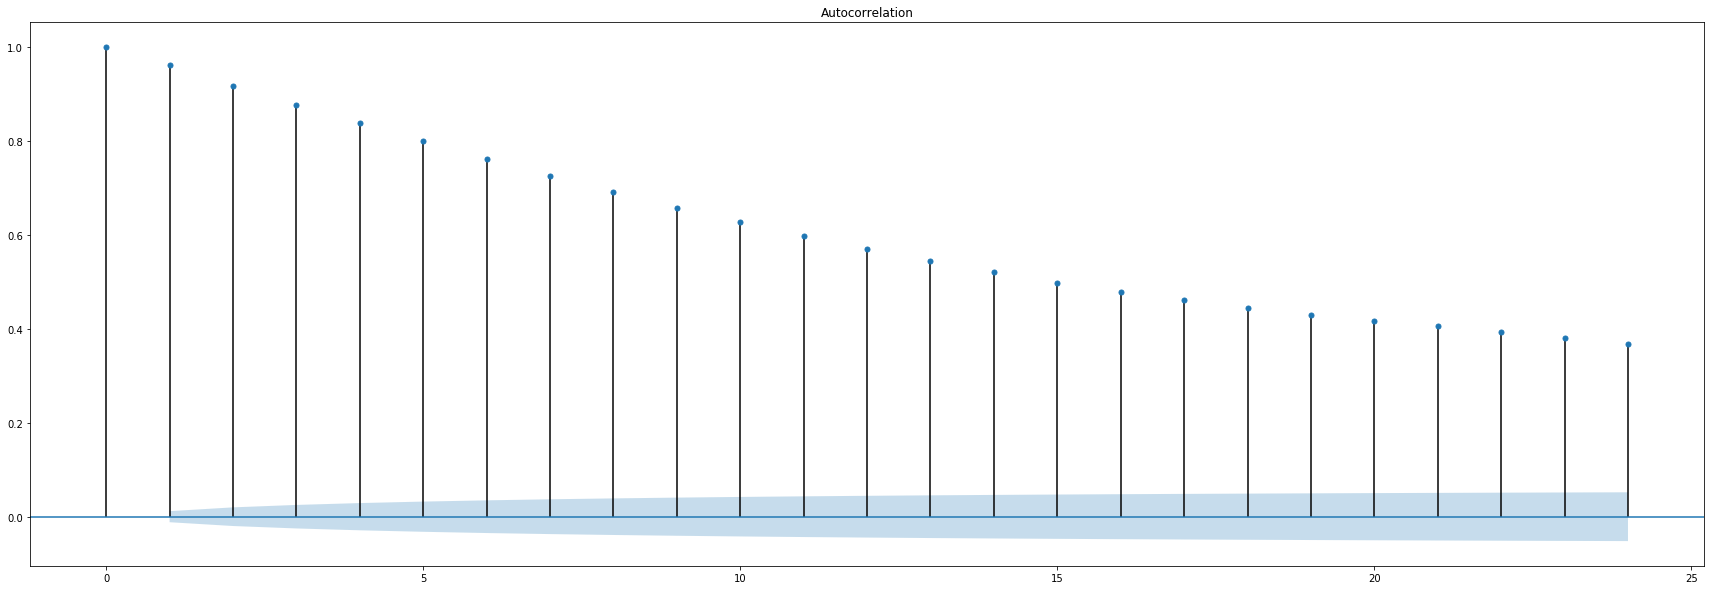

In [17]:
series=df[target_column]
fig, ax = plt.subplots(figsize=(30, 10))
fig=plot_acf(series,lags=24,ax=ax)
plt.show()

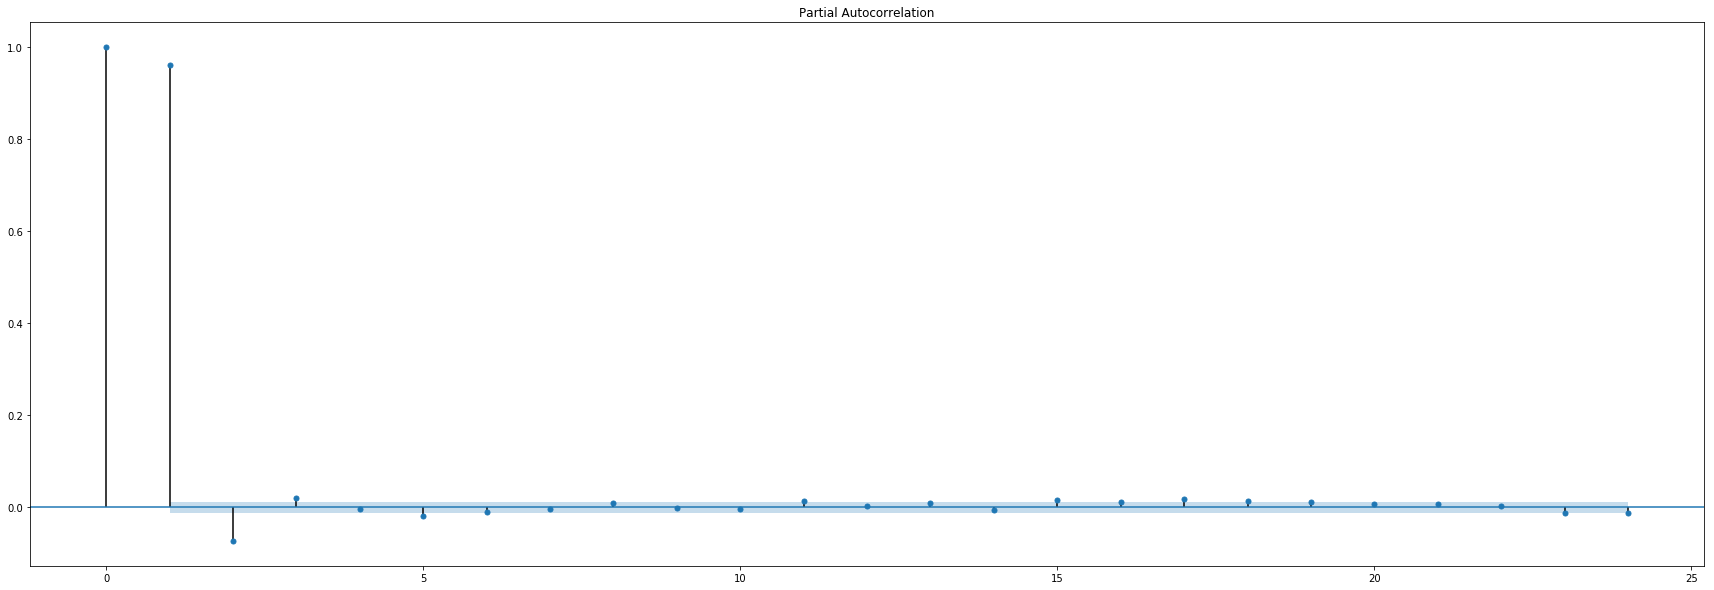

In [18]:
fig, ax = plt.subplots(figsize=(30, 10))
fig=plot_pacf(series,lags=24,ax=ax)
plt.show()

In [19]:
diff_series=residual.dropna()


In [20]:
#diff_series=(series-series.shift(1)).dropna()
X = diff_series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Lags used: %f' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -40.073618
p-value: 0.000000
Lags used: 49.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [21]:
residual

TIMESTAMP
2015-01-01 03:00:00         NaN
2015-01-01 04:00:00         NaN
2015-01-01 05:00:00         NaN
2015-01-01 06:00:00         NaN
2015-01-01 07:00:00         NaN
2015-01-01 08:00:00         NaN
2015-01-01 09:00:00         NaN
2015-01-01 10:00:00         NaN
2015-01-01 11:00:00         NaN
2015-01-01 12:00:00         NaN
2015-01-01 13:00:00         NaN
2015-01-01 14:00:00         NaN
2015-01-01 15:00:00    0.018262
2015-01-01 16:00:00   -0.001105
2015-01-01 17:00:00   -0.023614
2015-01-01 18:00:00   -0.042208
2015-01-01 19:00:00   -0.014783
2015-01-01 20:00:00    0.013738
2015-01-01 21:00:00    0.036403
2015-01-01 22:00:00    0.034838
2015-01-01 23:00:00    0.027509
2015-01-02 00:00:00    0.027101
2015-01-02 01:00:00    0.025548
2015-01-02 02:00:00    0.026288
2015-01-02 03:00:00    0.020730
2015-01-02 04:00:00    0.026586
2015-01-02 05:00:00    0.021497
2015-01-02 06:00:00    0.014353
2015-01-02 07:00:00    0.006980
2015-01-02 08:00:00   -0.002101
                         ...  